# Part 3 - History Dependence

In the previous session, we implicitely made the assumption that the our neuron's spiking behaviour depends only on time: We created a model whose components (basis functions) were functions of the step number, but not of anything else. We might justify this by saying that the neuron's behaviour is mostly determined by some external stimulus, and that our model is basically an attempt to recover the dynamics of that stimulus.

But neurons also have hidden, intrinsic processes. Take the refractory period, for instance: Directly after each spike, it is either impossible to fire another spike, or, a bit later, it would require a stronger external signal than in case there had not been a spike recently. So in other words, the spike probability would change depending on whether there was a spike recently (for example dropping to zero after each spike, then slowly recover).
Further, neurons interact. So, one neuron's spike probability can be modulated by the spikes of *other* neurons that occured in previous steps.

In this part, we will therefore expand our generalized linear model to include history features. That is, besides the purely time-dependent spline basis functions, its design matrix will include columns that in some way reflect the spiking history of the current cell (auto-history) as well as that of other cells (cross-history). 

The motivation for this is twofold: First, we hope the additional information will lead to more accurate models, so that we can classify with higher accuracy from which cell or which condition a given spike train comes (hint, hint). Second, the new model consists of separate "components" that we can interpret: We'll see what influence a spike on our own neuron or some other neuron has on the firing probability, and we can now take the remaining, purely time-dependent model component as a more accurate reflection of the external stimulus, because that component now doesn't need to account for weird neuron-internal effects anymore. So in some sense, the decoding will get more accurate.

**First, execute these code snippets from part 2 (data loading, resolution reduction, adaptive knot placement...):**

In [129]:
from matplotlib.pyplot import *
%matplotlib inline
import numpy as np
import splines
from scipy.ndimage.filters import gaussian_filter1d

def reduce_resolution(array,factor,sum_spikes=True):
    """ 
    Reduces the temporal resolution of an array of spike trains.
    
    This can cause multiple spikes to fall into one time bin, i.e. the
    returned array can contain integers > 1.
    If sum_spikes is set to False, we do not sum spike counts. Instead,
    any spike counts > 1 in one bin are truncated down to 1. In that case,
    a binary array is returned, but some spikes may be lost.
    
    Arguments:
        array: 4D numpy array. Reduction will occur along the last dimension (T).
        factor: integer to divide the number of time bins by.
        sum_spikes: If false, truncate the number of spikes per bin to 1.
      
    Returns:
        4D numpy array, similar as input but last dimension with length T/factor.
    """
    assert type(factor) is int
    reduced_shape = (array.shape[0],array.shape[1],array.shape[2],array.shape[3]/np.round(factor))
    spikes_reduced = np.zeros(reduced_shape) # create a shortened result array
    for idx in np.ndindex(array.shape[0:3]): # for all indices along the first 3 dimensions..
        spiketimes = (array[idx].nonzero()[0] / factor).astype(int) # get spiketimes, divide by factor
        for spiketime in spiketimes: # loop manually, since numpy indexing treats index lists as sets
            spikes_reduced[idx[0],idx[1],idx[2],spiketime] += 1 # increment result array by 1 at the divided spiketimes
    
    if not sum_spikes:
        spikes_reduced  = spikes_reduced >= 1
    spikecount_difference = (np.sum(array) - np.sum(spikes_reduced)).astype(int)
    if spikecount_difference > 0:
        print "Lost "+str(spikecount_difference)+" spikes through resolution reduction."
    return spikes_reduced    

def find_percentiles(y, num_percentiles, return_thresholds=False):
    """ Finds `num_percentiles` equally spaced percentiles of `y` (a monotonically increasing vector),
    i.e. it approximates the inverse `x` of the function `y=f(x)` 
    at `num_percentiles` equally spaced `y`-values between 0 and `y[-1]`.
    
    Arguments:
        y:                  a sequence of monotonically increasing function values
        num_percentiles:    number of percentiles to find between 0 and `y[-1]`.
        return_threshold:   boolean value to indicated whether or not to return the thresholds, too
    Returns:
        percentiles:        `y`-values of the percentiles
        [thresholds:        `x`-values of the percentiles]
    """
    thresholds = np.linspace(0,y[-1],num_percentiles+1)
    percentiles = np.zeros_like(thresholds)
    
    current = 1
    for step in range(T):
        if y[step] > thresholds[current]:
            percentiles[current] = step
            current +=1
    
    percentiles[-1] = len(y)
    if return_thresholds:
        return percentiles, thresholds
    else:
        return percentiles

def calc_cum_abs_deriv(y, sigma=10, order=1):
    """ Calculates the curvature of the spike count vector `y`"""
    return np.cumsum(np.abs(gaussian_filter1d(y, sigma=sigma, order=order)))



# Load the data:
with np.load('data.npz') as archive:
    original_spikes = archive['spikes_outputencoding']

# reduce resolution:
resolution_reduction = 5 # <-- resolution reduction factor
spikes = reduce_resolution(original_spikes,factor=resolution_reduction, sum_spikes=True)

# choose a subset of the data (one cell & one experimental condition):
cell = 1
condition = 1
N = spikes.shape[2] # number of trials
T = spikes.shape[3] # length of a trial
all_spiketrains = spikes[cell,condition,:,:] # N x T array containing only the subset of data that we picked
sum_spiketrains = all_spiketrains.sum(axis=0)
spiketrain0     = all_spiketrains[0]


sigma               = 100/resolution_reduction
spline_order        = 3
num_knots           = 50


cumulative_derivative = calc_cum_abs_deriv(sum_spiketrains, sigma=sigma, order=1)
adaptive_rate_knots   = find_percentiles(cumulative_derivative, num_knots)
knots                 = splines.augknt(adaptive_rate_knots, spline_order)
rate_spline_bases     = np.array(splines.spcol(range(T),knots,spline_order))

## Auto-history in a single trial

We first focus on history effects in a single spike train, then later expand the model back to multiple trials.

As mentioned above, our goal is to add new model features (i.e. new columns in the design matrix) to answer this question: "What is the systematic change in spike probability at the current step that is caused by a spike 1 (2, 3, 4,...) time steps ago".

A simple way to approach this would be to add one new feature for each length of time we look back. So, we could do the following for each length of time $\delta \in \{1,2,3,4,...,20\}$:
- add an additional column to the design matrix
- in that column, at row (time step) $t$, write a 1 if there was a spike at $t-\delta$.

The rest of the design matrix -- what we call the temporal component -- would remain as in the last session, i.e. just various basis splines evaluated on $(0,T)$.

If we fit this expanded model to our spike data, we would see for example that the weight at the $\delta = 1$ column comes up as negative. Let's try to explain why. We know that in our data, there is almost never a spike directly at times directly after a spike *did* occur, because of refractoriness. So of course, we would like the model to assign a spiking probability of zero at those time steps. But the model is in a conflict at time steps like that: Our temporal component says that the spike probability is nonzero (since that component changes slowly and so needs to account for all the nonzero spiking activity going on in the general vicinity), but the data at that particular step reliably says there is nothing. If the model has no history component (as in the last session), it will solve this by decreasing its weights on the temporal component a little bit. Now, on the other hand, it can solve it by setting a negative weight on the newly introduced $\delta = 1$ column: This results in the desired low probabilities assigned to time steps directly following spikes, all while the slow-changing temporal component can remain as high as it needs to be to explain the surrounding spiking activity. So the interpretation of a negative weight at the  $\delta = 1$ column is: One step after a spike, the spike probability drops down. The other 19 new columns would add similar new degrees of freedom, and similar interpretations.

That is the basic idea that carries the rest of this session -- and the same basic idea applies to cross-history. The only problem is that the mentioned scheme is too wasteful: It would require 20 new parameters. It seems implausible that the impact of a spike, say, 17 steps back should be vastly different from the impact of a spike from 19 steps back, so why waste separate parameters on these differences? (Although maybe there *is* a big difference between whether the spike happened 1 step ago or 3 steps ago.)

Hence, instead of adding a separate column for each length of time that we look back, we will add only few columns, filled with increasingly smeared out versions of past spikes -- more smeared out the longer ago the spike took place. This will become more concrete after you solved the following exercises:



### Exercise 1a: Auto-history kernels

We want to convolve (filter) our spiketrain with a number of increasingly broad kernels functions. Concretely, the design matrix column responsible for very recent spikes will be the result of filtering with a kernel situated close to 0 and relatively sharp, while the column more responsible for spikes from 10 to 20 steps ago will be the result of filtering with a kernel situated further out and broader.

You will now create a set of such kernel functions -- using the familiar tools to create spline basis functions.

* create a logarithmically spaced knot vector. To do this,
    * use np.logspace to create a list of `history_num_knots` numbers between 0 and and $log_{10}($ `history length` $)$ and feed it into the familiar `spline.augknt` function.
    * delete the last knot! this forces the last kernel function to wind down to 0, instead of ending discontinuously.



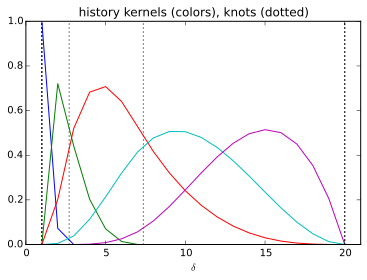

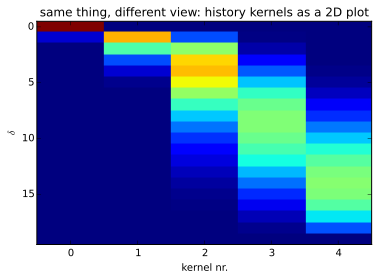

In [275]:
import splines
import statsmodels.api as sm

history_length = 100/resolution_reduction
history_spline_order = 3                          
history_num_knots = 4

# Create spline history kernel
# history_knots = ...

history_knots = splines.augknt(np.logspace(0,np.log10(history_length),history_num_knots),history_spline_order)  # solution 
history_knots = history_knots[:-1] # solution

history_x = np.linspace(1+1e-10,history_length,history_length)                                 
history_spline_bases = splines.spcol(history_x,history_knots,history_spline_order)
num_history_bases  = history_spline_bases.shape[1]


figure()
plot(np.tile(history_knots,(2,1)),np.zeros((2,len(history_knots)))+np.array([[0],[1]]), "k:")
plot(history_x,history_spline_bases);
xlim([0,history_length+1])
xlabel(r"$\delta$")
title("history kernels (colors), knots (dotted)")

figure()
imshow(history_spline_bases,aspect='auto',interpolation='nearest')
ylabel(r"$\delta$")
xlabel("kernel nr.")
title("same thing, different view: history kernels as a 2D plot")

### Exercise 1b: History component of the design matrix

We mentioned that we expand our model's design matrix by additional columns -- not exactly one for each length of time that we look back for previous spikes for, but an approximation of that. The intuition is the same: We write something in the respective column, at time $t$, whenever there was a spike in the relevant preceding timeframe.

* Create the 2D array `history_dm` with dimensions T x `num_history_bases`. 
* In the `i`'th column, it should contain a convolution of the single spiketrain `spiketrain0` with the `i`'th history kernel (that you defined in 1a). Two hints about that:
    * use the `np.convolve` function with `mode='same'`.
    * each kernel has length `history_length`. you need to prepend as many zeros in front of it (that is, create a "zero-padded" kernel of length 2 \* `history_length`) and apply the convolution only to that one.

(-0.1, 1.1)

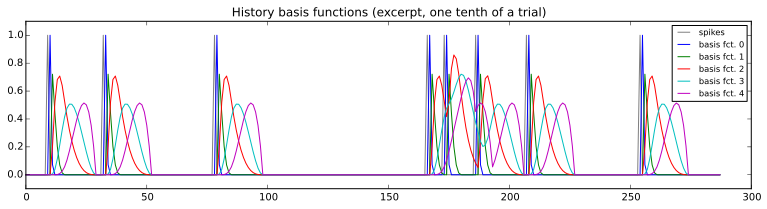

In [226]:
# history_dm = ...
history_dm = np.zeros((T,num_history_bases)) # solution
for i in range(num_history_bases):  # solution
    padded_kernel = np.hstack([np.zeros_like(history_spline_bases[:,i]),history_spline_bases[:,i]])  # solution
    history_dm[:,i] = np.convolve(spiketrain0, padded_kernel, "same")  # solution


figure(figsize=(13,3))
plot(spiketrain0[:T/10],'gray')
plot(history_dm[:T/10])
legend(["spikes"]+["basis fct. "+str(i) for i in range(num_history_bases)],fontsize='small')
title("History basis functions (excerpt, one tenth of a trial)")
ylim(-0.1,1.1)

### Exercise 1c: Putting together the design matrix (history + rate)

Stack together the `history_dm` with the old design matrix from last time, which we prepared for you under the name `rate_spline_bases`. The result should be a 2D array `single_trial_dm` with `T` rows and a few more columns than the old design matrix.

If all worked, you will see a rather large plot of the design matrix with history component, next to the target spike train. 

Perhaps with this picture, the explanation given in the beginning begins to make sense: To approximate the spiketrain (shown left), a weighted sum of the columns of the design matrix is sought. With the 5 new history columns, we can now more easily explain gaps between spikes without needing to touch the slow, temporal component.

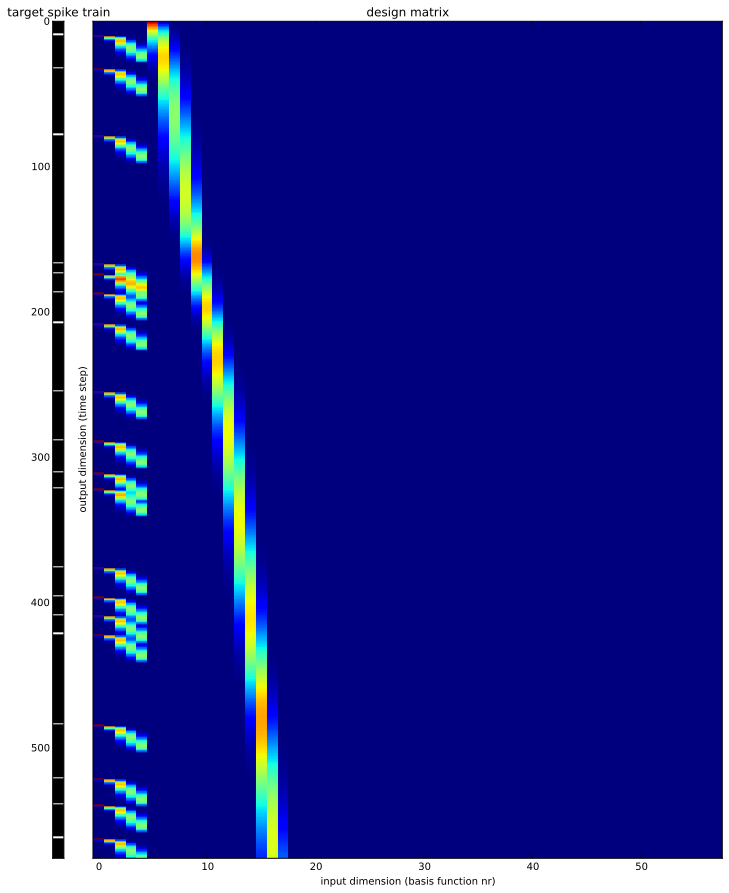

In [273]:
# single_trial_dm = ...
single_trial_dm = np.hstack([history_dm, rate_spline_bases])  # solution


assert single_trial_dm.shape == (T,num_history_bases+rate_spline_bases.shape[1])

figure(figsize=(12,15))
ax1 = subplot2grid((1,50),(0, 0),colspan=(1))
imshow(spiketrain0.reshape(-1,1)[:T/5,:], aspect="auto", interpolation="nearest",cmap='gray')
title("target spike train")
xticks([])

ax2 = subplot2grid((1,50),(0, 3),colspan=(48))
imshow(single_trial_dm[:T/5,:], aspect="auto", interpolation="nearest")
yticks([])
ylabel("output dimension (time step)")
xlabel("input dimension (basis function nr)")
title("design matrix")


### Fit model with rate and history component on a single trial

lets do it!

In [274]:
spikes_nospikes = np.array([spiketrain0,resolution_reduction-spiketrain0]).T

model = sm.GLM(spikes_nospikes,single_trial_dm,family=sm.families.Binomial())
fitted_model = model.fit()

prediction = fitted_model.predict()

### 1d: Analyzing the model

As mentioned above, we can decompose and interpret the different sections of this model separately.

To do this, we select the fitted weights of the different components and apply them to their respective basis functions.

* create the vector `hist_component` by applying the correct section of `fitted_model.params` to `history_spline_bases`. What would be an obvious interpretation of the resulting plot?

* create the vector `rate_component` by applying the correct section of `fitted_model.params` to `rate_spline_bases`. The plot of the temporal component is probably not very impressive -- we'll try again later with more trials.


This cell also plots the model's complete output (i.e. the estimated firing probability) of (parts of) this single spiketrain, together with the spikes.


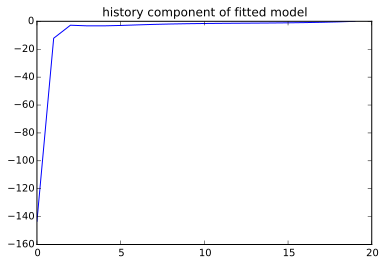

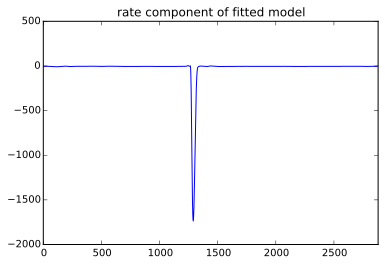

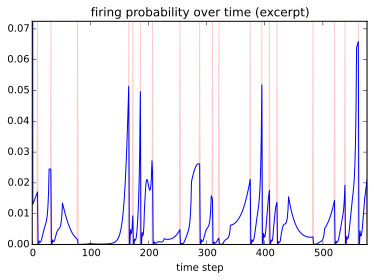

In [293]:
figure()
title('history component of fitted model')
# your code here:
# hist_component = np.dot(history_spline_bases,fitted_model.params[...])
hist_component = np.dot(history_spline_bases,fitted_model.params[:history_num_knots+1]) # solution
plot(hist_component)
xlim([0,history_spline_bases.shape[0]])

figure()
title('rate component of fitted model')
# rate_component = ...
rate_component = np.dot(rate_spline_bases,fitted_model.params[history_num_knots+1:]) # solution
plot(rate_component)
xlim([0,T])


figure()
up = np.max(prediction[10:T/5-10])*1.1
plot(spiketrain0*up,'r',alpha=0.2)
plot(prediction[:T])
xlim([0,T/5])
ylim([0,up])
title('firing probability over time (excerpt)')
xlabel('time step')


### Exercise 1d: Adding cross history features

Adding inputs from other cells works very similarly to the auto-history case from exercise 1a, except that now we convolve not with spikes from our own cell, but those from other cells. (In other words, auto-history is the special case.)


* For each of the selected cells whose history we consider (`cross_cells`), create a mini-designmatrix `cross_cell_dm` of dimensions `T` x `num_history_bases`. Its `i`'th column should contain the convolution of the spikes from the currently selected cell with the `i`'th history kernel -- just as in 1a. Use the `np.convolve` function in the same way, including the zero padding of the convolution kernel.

The provided code will then stack together these individual per-cell matrices, creating a single `T` x `num_history_bases` \* `len(cross_cells)` array. 

Then, it prepends all of this to our main design matrix.

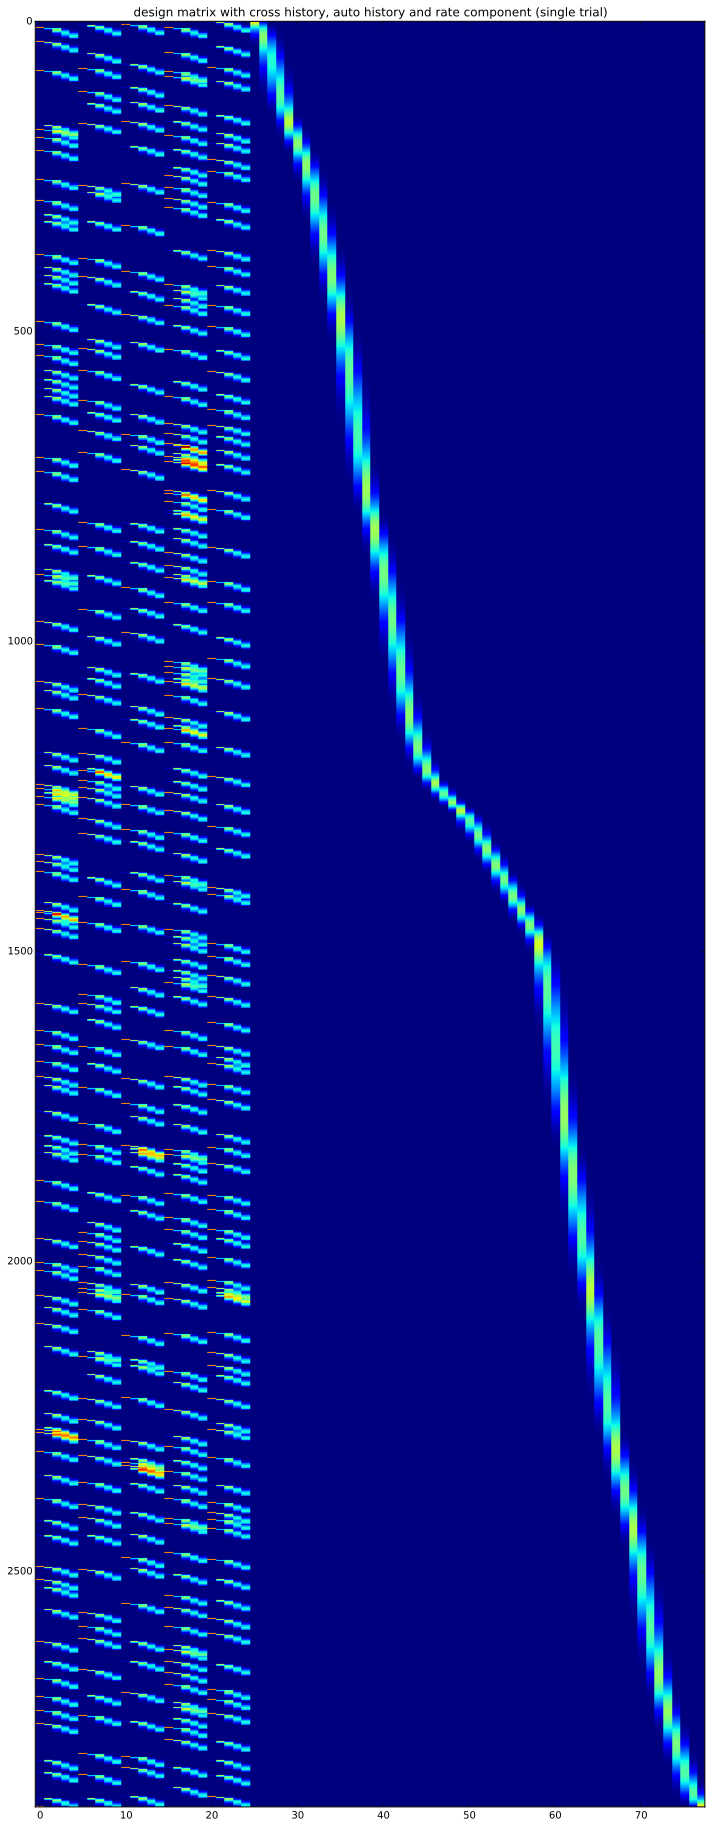

In [298]:
cross_cells        = [0,2,3,4]
cross_spiketrain0  = spikes[cross_cells,condition,0,:]


cross_cell_dms = []

for c in range(len(cross_cells)):
    cross_cell_dm = np.zeros((T,num_history_bases))
    for i in range(num_history_bases):
#        padded_kernel = ...
#        cross_cell_dm[...] = ...
        padded_kernel = np.hstack([np.zeros_like(history_spline_bases[:,i]),history_spline_bases[:,i]])  # solution
        cross_cell_dm[:,i] = np.convolve(cross_spiketrain0[c], padded_kernel, "same")                # solution
    cross_cell_dms.append(cross_cell_dm)
    
# stack up the history basis functions for different cross cells
cross_history_dm = np.hstack(cross_cell_dms)

# stack it all up
single_trial_dm = np.hstack([history_dm, cross_history_dm, rate_spline_bases])

figure(figsize=(12,32))
imshow(single_trial_dm, aspect="auto", interpolation="nearest")
title("design matrix with cross history, auto history and rate component (single trial)")

### fitting all of it (single trial)

In [299]:
model = sm.GLM(spikes_nospikes,single_trial_dm,family=sm.families.Binomial())
fitted_model = model.fit()
prediction = fitted_model.predict()

In [300]:
auto_history_kernel = np.dot(history_spline_bases,fitted_model.params[:num_history_bases])
cross_history_kernels = np.hstack([np.dot(history_spline_bases,fitted_model.params[(i+1)*num_history_bases:(i+2)*num_history_bases]).reshape((-1,1)) for i in range(4)])

auto_history_component = np.dot(single_trial_dm[:,:num_history_bases],fitted_model.params[:num_history_bases])
cross_history_components = np.dot(single_trial_dm[:,num_history_bases:(len(cross_cells)+1)*num_history_bases],fitted_model.params[num_history_bases:(len(cross_cells)+1)*num_history_bases]).reshape((-1,len(cross_cells)))
rate_component =np.dot(single_trial_dm[:,(len(cross_cells)+1)*num_history_bases:],fitted_model.params[(len(cross_cells)+1)*num_history_bases:])

#### plot the components that were learnt and the predicted firing rate for 1 trial (w/ autohistory)

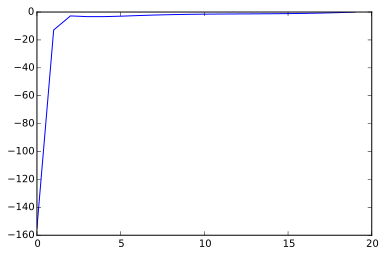

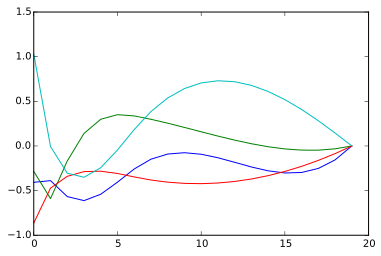

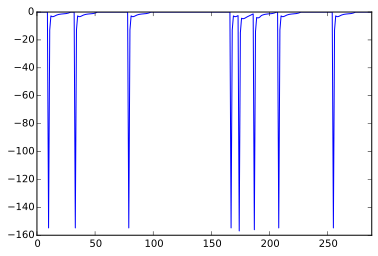

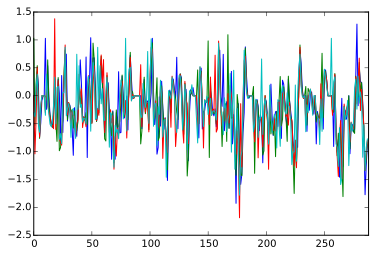

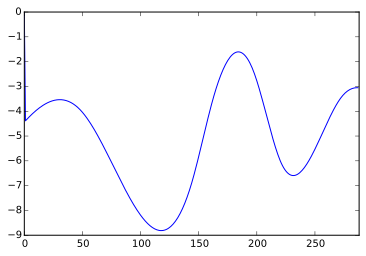

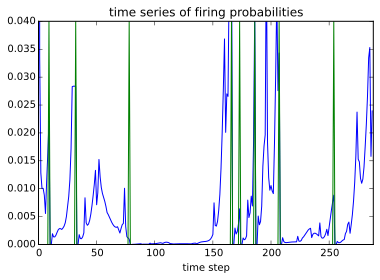

In [301]:
figure()
plot(auto_history_kernel)
xlim([0,len(auto_history_kernel)])

figure()
plot(cross_history_kernels)
xlim([0,len(auto_history_kernel)])

figure()
plot(auto_history_component[:T/10])
xlim([0,T/10])

figure()
plot(cross_history_components[:T/10])
xlim([0,T/10])
figure()
plot(rate_component[:T/10])
xlim([0,T/10])

figure()
plot(prediction[:T/10])
plot(spiketrain0[:T/10]*0.04)
xlim([0,T/10])
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')

#### calculate design-matrix for all trials

In [25]:
num_basis_functions = history_spline_bases.shape[1]
cells =[cell] + cross_cells

dm_list = []
for trial in range(N):
    # Build design-matrix for trial t
    trial_dms = []
    for c,cell in enumerate(cells):
        cell_history_dm = np.zeros((T,num_history_bases))
        for i in range(num_history_bases):
            cell_history_dm[:,i] = np.convolve(spikes[cell,condition,trial,:], np.hstack([np.zeros_like(history_spline_bases[:,i]),history_spline_bases[:,i]]), "same")
        trial_dms.append(cell_history_dm)
    trial_dms.append(rate_spline_bases)
    dm_list.append(trial_dms)

dm = np.array(np.bmat(dm_list))

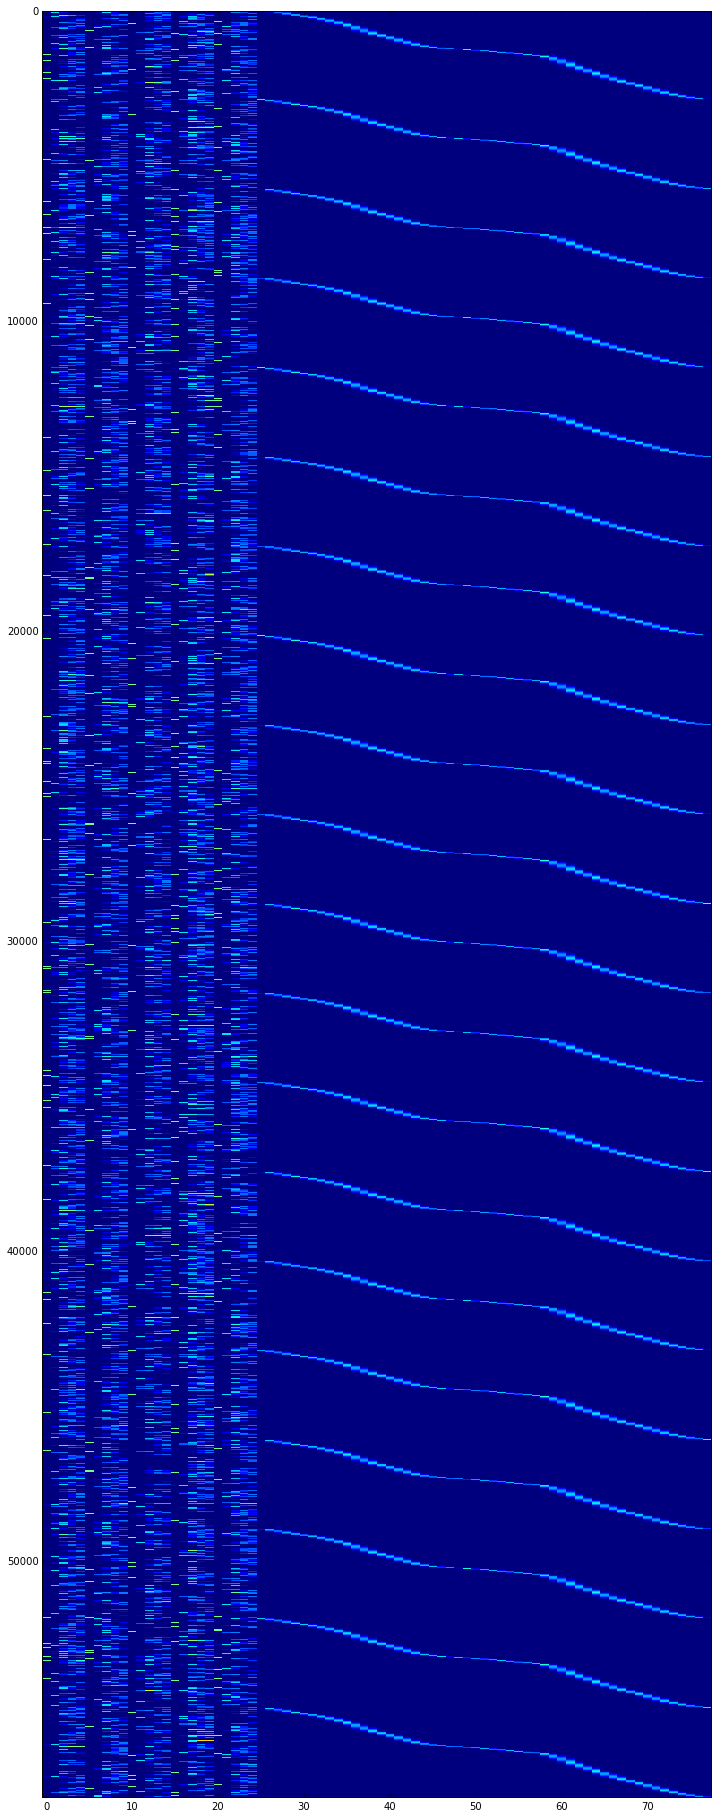

In [26]:
figure(figsize=(12,32))
imshow(dm, aspect="auto", interpolation="nearest")

#### fit model with rate, auto-history and cross-history component on all trials

In [27]:
spikes_nospikes = np.array([all_spiketrains.ravel(),resolution_reduction-all_spiketrains.ravel()]).T

model = sm.GLM(spikes_nospikes,dm,family=sm.families.Binomial())
fitted_model = model.fit()

prediction = fitted_model.predict()

#### plot components that were learn on all trials

In [29]:
auto_history_kernel = np.dot(history_spline_bases,fitted_model.params[:num_history_bases])
cross_history_kernels = np.hstack([np.dot(history_spline_bases,fitted_model.params[(i+1)*num_history_bases:(i+2)*num_history_bases]).reshape((-1,1)) for i in range(4)])

auto_history_component = np.dot(single_trial_dm[:,:num_history_bases],fitted_model.params[:num_history_bases])
cross_history_components = np.dot(single_trial_dm[:,num_history_bases:(len(cross_cells)+1)*num_history_bases],fitted_model.params[num_history_bases:(len(cross_cells)+1)*num_history_bases]).reshape((-1,len(cross_cells)))
rate_component =np.dot(single_trial_dm[:,(len(cross_cells)+1)*num_history_bases:],fitted_model.params[(len(cross_cells)+1)*num_history_bases:])

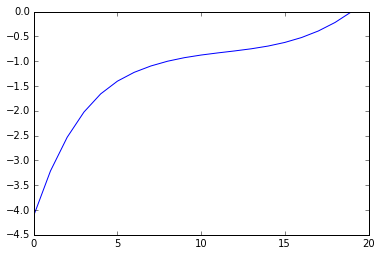

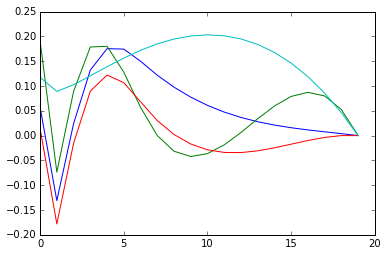

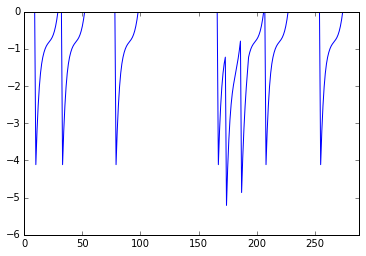

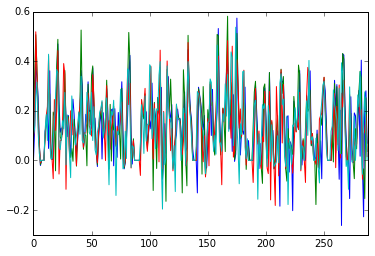

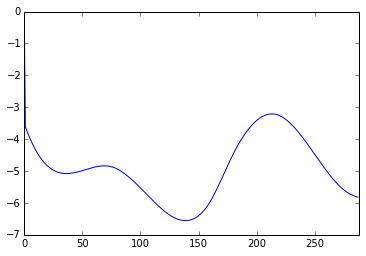

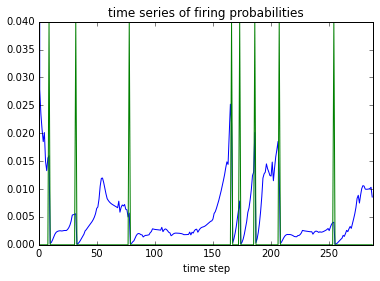

In [30]:
figure()
plot(auto_history_kernel)
xlim([0,len(auto_history_kernel)])

figure()
plot(cross_history_kernels)
xlim([0,len(auto_history_kernel)])

figure()
plot(auto_history_component[:T/10])
xlim([0,T/10])

figure()
plot(cross_history_components[:T/10])
xlim([0,T/10])
figure()
plot(rate_component[:T/10])
xlim([0,T/10])

figure()
plot(prediction[:T/10])
plot(spiketrain0[:T/10]*0.04)
xlim([0,T/10])
ylim([0,0.04])
title('time series of firing probabilities')
xlabel('time step')

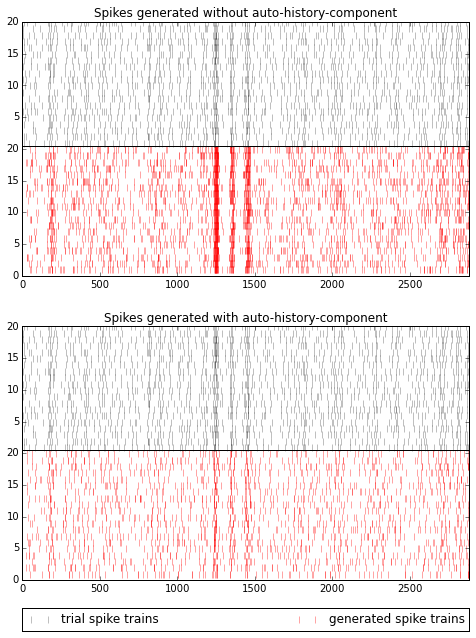

In [31]:
from numpy.random import binomial as binomial_rv

r_and_c_component = np.dot(dm[:,num_history_bases:],fitted_model.params[num_history_bases:]).reshape((N,T))

figure(figsize=(8,10))
ax = [subplot(2,1,1), subplot(2,1,2)]


for i in range(2):
    ax[i].set_title("Spikes generated %s auto-history-component" % ("without" if i==0 else "with"))
    spike_train = np.zeros((N,T))
    for trial in range(N):
        for step in range(history_length,T):
            if i == 0:
                eta = r_and_c_component[trial,step]
            else:
                eta = r_and_c_component[trial,step] + np.dot(spike_train[trial,step-history_length:step],auto_history_kernel)
            p = 1/(1+np.exp(-eta))
            spike_train[trial,step] = binomial_rv(resolution_reduction, p)
    spike_y, spike_t = np.where(spike_train)
    red_dots= ax[i].plot(spike_t,20-spike_y,"r|",alpha=0.7,ms=7)
    
    
spike_y, spike_t = np.where(all_spiketrains)
for i in range(2):
    black_dots = ax[i].plot(spike_t,40-spike_y,"k|",alpha=0.5,ms=7)
    ax[i].plot([0,T],[20.5,20.5],"k-")
    ax[i].set_yticks(np.arange(0,41,5))
    ax[i].set_yticklabels(np.hstack([np.arange(0,21,5),np.arange(5,21,5)]))
    ax[i].set_xlim([0,T])
ax[1].legend([black_dots[0], red_dots[0]], ["trial spike trains","generated spike trains"], bbox_to_anchor=(0., -0.2, 1., -0.2), loc=3, ncol=2, mode="expand", borderaxespad=0)

That's it for Part 3!
==========================